# Project File

Following two cells designed to open and process the two TSV files containing the propaganda information

In [1]:
#imports generated based off requirements throughout code
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setting up the training and validation files

In [2]:
#Code adapted from Week 7 lab
import os
parentdir = "/Users/finpearson/Desktop/Github/ANLE---Python-/Project/Project_Propaganda_Files"
train_file= "propaganda_train.tsv"
val_file= "propaganda_val.tsv"
train_path=os.path.join(parentdir,train_file)
val_path=os.path.join(parentdir,val_file)

In [3]:
#Code adapted from week 7 lab
train_df=pd.read_csv(train_path,delimiter="\t",quotechar='|')
#display(train_df.head(20))

val_df=pd.read_csv(val_path,delimiter="\t",quotechar='|')
#display(val_df.head(20))

## Preprocessing data  

In [4]:
#Code grabbed from week 7 lab
#Grabs the respective data from each of the columns of the dataframe
train_sentences = train_df['tagged_in_context'].values
#print(train_sentences)
train_labels = train_df['label'].apply(lambda x: 1 if x != 'not_propaganda' else 0)
#print(train_labels)

In [5]:
val_sentences = val_df['tagged_in_context'].values
#print(val_sentences)
#labels = train_df['label'].values
val_labels = val_df['label'].apply(lambda x: 1 if x != 'not_propaganda' else 0)
#print(val_labels)

# Bag Of Words Classifier

The cell below trains the Multinomial Naive Bayes classifier

In [174]:
#Code adapted from OpenAI's ChatGPT
vectorizer = CountVectorizer(max_df=0.75, min_df=2, ngram_range=(1, 2))

# Generate BoW representation of the text data
X = vectorizer.fit_transform(train_sentences)

# Train the classifier
classifier = MultinomialNB(alpha=1)
classifier.fit(X, train_labels)

val_X = vectorizer.transform(val_sentences)

# Make predictions using the trained classifier
val_predictions = classifier.predict(val_X)

# Calculate accuracy
val_accuracy = accuracy_score(val_labels, val_predictions)
print("Validation Accuracy:", val_accuracy)

Validation Accuracy: 0.734375


# Bernoulli NB cross grid search hyperparameter tuning

In [100]:
#Code adapted from OpenAI's ChatGPT

# Define the pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer()),  # CountVectorizer is part of the pipeline
    ('clf', BernoulliNB())
])

# Define the parameter grid
param_grid = {
    'vect__max_df': [0.5, 0.75, 1.0],
    'vect__min_df': [1, 2, 5],
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__alpha': [0.1, 0.5, 1.0],
    'vect__stop_words': [None, 'english'],  # Add stop words option
    'vect__max_features': [1000, 5000, None],  # Control vocabulary size
    'vect__binary': [True, False],  # Binary features option
}

# Create GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)

# Perform grid search on the training data
grid_search.fit(train_sentences, train_labels)

# Print the best parameters found
print("Best parameters:", grid_search.best_params_)

# Evaluate the best model on the validation data
val_accuracy = grid_search.best_estimator_.score(val_sentences, val_labels)
print("Validation Accuracy with best model:", val_accuracy)


Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best parameters: {'clf__alpha': 0.1, 'vect__binary': True, 'vect__max_df': 0.5, 'vect__max_features': 5000, 'vect__min_df': 1, 'vect__ngram_range': (1, 2), 'vect__stop_words': None}
Validation Accuracy with best model: 0.7484375


# Multinomial cross grid search hyperparamter tuning

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best parameters: {'clf__alpha': 0.5, 'vect__binary': True, 'vect__max_df': 1.0, 'vect__max_features': None, 'vect__min_df': 1, 'vect__ngram_range': (1, 2), 'vect__stop_words': None}
Validation Accuracy with best model: 0.73125


<Figure size 1000x700 with 0 Axes>

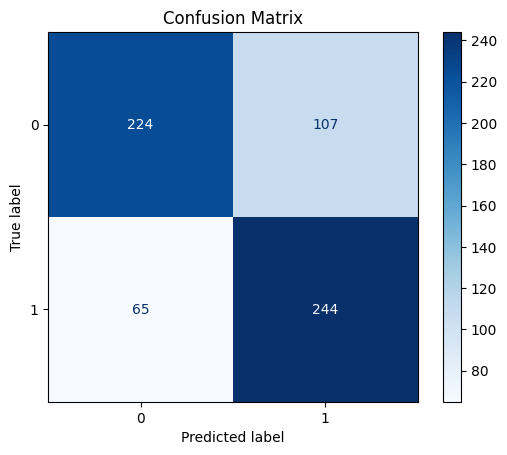

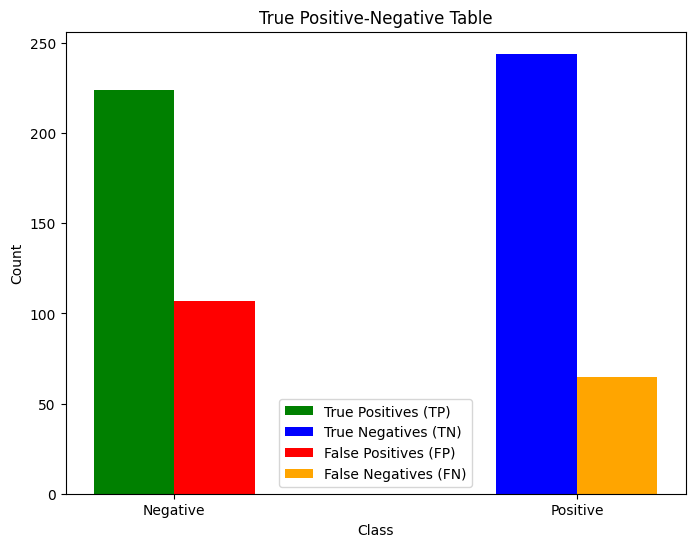

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

#Code adapted from OpenAI's ChatGPT

# Define the pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer()),  # CountVectorizer is part of the pipeline
    ('clf', MultinomialNB())
])

# Define the parameter grid
param_grid = {
    'vect__max_df': [0.5, 0.75, 1.0],
    'vect__min_df': [1, 2, 5],
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
    'clf__alpha': [0.1, 0.5, 1.0],
    'vect__stop_words': [None, 'english'],  # Add stop words option
    'vect__max_features': [1000, 5000, None],  # Control vocabulary size
    'vect__binary': [True, False],  # Binary features option
}

# Create GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)

# Perform grid search on the training data
grid_search.fit(train_sentences, train_labels)

# Print the best parameters found
print("Best parameters:", grid_search.best_params_)

# Predict the labels for the validation data
val_predictions = grid_search.best_estimator_.predict(val_sentences)

# Evaluate the best model on the validation data
val_accuracy = grid_search.best_estimator_.score(val_sentences, val_labels)
print("Validation Accuracy with best model:", val_accuracy)

# Compute the confusion matrix
cm = confusion_matrix(val_labels, val_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.best_estimator_.classes_)
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Define class names
class_names = ['Negative', 'Positive']

# Calculate True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN)
TP = cm[0, 0]
TN = cm[1, 1]
FP = cm[0, 1]
FN = cm[1, 0]

# Plotting the true positive-negative table with each metric on its own line
plt.figure(figsize=(8, 6))

# Define the positions for each class
class_positions = np.arange(len(class_names))

# Define the width for each bar
bar_width = 0.2

# Plot True Positives (TP)
plt.bar(class_positions - 0.5 * bar_width, [TP, 0], bar_width, color='green', label='True Positives (TP)')

# Plot True Negatives (TN)
plt.bar(class_positions - 0.5 * bar_width, [0, TN], bar_width, color='blue', label='True Negatives (TN)')

# Plot False Positives (FP)
plt.bar(class_positions + 0.5 * bar_width, [FP, 0], bar_width, color='red', label='False Positives (FP)')

# Plot False Negatives (FN)
plt.bar(class_positions + 0.5 * bar_width, [0, FN], bar_width, color='orange', label='False Negatives (FN)')

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('True Positive-Negative Table')
plt.xticks(class_positions, class_names)
plt.legend()
plt.show()


## Support vector machine Using TD-IDF

In [ ]:
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

#Code adapted from OpenAI's ChatGPT

# Initialize SVM classifier with TF-IDF Vectorizer
svm_classifier = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Convert text to TF-IDF features
    ('svm', SVC(kernel='rbf'))  # SVM classifier with linear kernel
])

# Train the SVM classifier
svm_classifier.fit(train_sentences, train_labels)

# Predict on the validation set
val_predictions = svm_classifier.predict(val_sentences)

# Calculate accuracy
val_accuracy = accuracy_score(val_labels, val_predictions)
print("Validation Accuracy:", val_accuracy)

Validation Accuracy: 0.71875


## Neural Language Model

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5090 - loss: 0.6919 - val_accuracy: 0.5344 - val_loss: 0.6874
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5493 - loss: 0.6812 - val_accuracy: 0.6281 - val_loss: 0.6539
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6408 - loss: 0.6384 - val_accuracy: 0.4953 - val_loss: 0.6949
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6380 - loss: 0.6240 - val_accuracy: 0.5719 - val_loss: 0.7283
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6993 - loss: 0.5896 - val_accuracy: 0.6422 - val_loss: 0.6343
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7606 - loss: 0.4884 - val_accuracy: 0.7312 - val_loss: 0.5454
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7915 - loss: 0.4332 - val_accuracy: 0.6984 - val_loss: 0.5693
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7246 - loss: 0.5258 - val_accuracy: 0.6859 - val_loss:

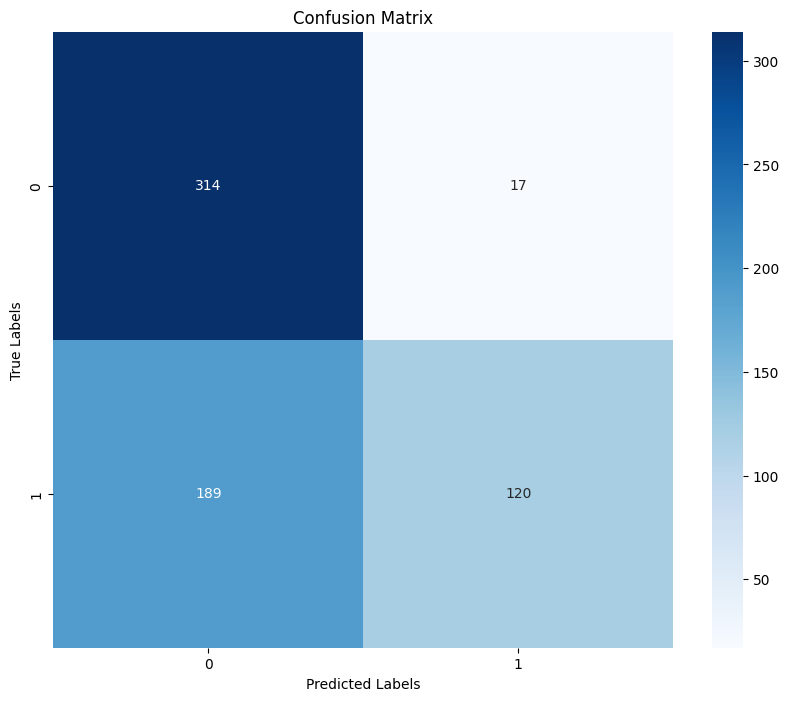

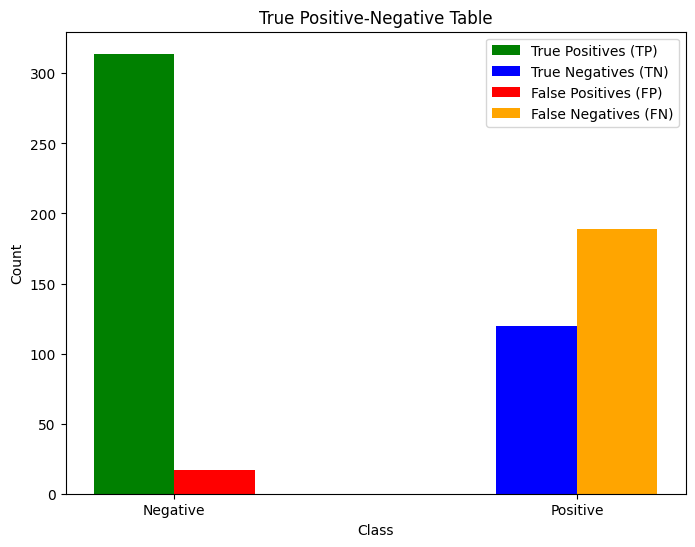

In [30]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#Code adapted from OpenAI's ChatGPT

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_sentences)
train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sequences = tokenizer.texts_to_sequences(val_sentences)

num_epochs = 10

# Pad sequences to ensure uniform length
#max_sequence_length = 100  # Adjust as needed
max_sequence_length_train = max(len(sequence) for sequence in train_sequences)

# Find the maximum sequence length in the validation set
max_sequence_length_val = max(len(sequence) for sequence in val_sequences)

# Determine the maximum sequence length across both training and validation sets
max_sequence_length = max(max_sequence_length_train, max_sequence_length_val)
#max_sequence_length = 100
train_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length)
val_sequences = pad_sequences(val_sequences, maxlen=max_sequence_length)

# Define your neural network architecture
vocab_size = len(tokenizer.word_index) + 1  # Add 1 for the padding token
embedding_dim = 100  # Adjust as needed
num_classes = 2  # 2 used as this section is binary classification related

model = models.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    layers.GlobalAveragePooling1D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_sequences, train_labels, epochs=num_epochs, validation_data=(val_sequences, val_labels))

# Evaluate the model
val_loss, val_acc = model.evaluate(val_sequences, val_labels)
print(f'Test accuracy: {val_acc:.4f}')

# Predict labels for the validation set
val_pred_probs = model.predict(val_sequences)
val_preds = np.argmax(val_pred_probs, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(val_labels, val_preds)

# Print classification report for more detailed metrics
print(classification_report(val_labels, val_preds))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Define class names
class_names = ['Negative', 'Positive']

# Calculate True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN)
TP = conf_matrix[0, 0]
TN = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

# Plotting the true positive-negative table with each metric on its own line
plt.figure(figsize=(8, 6))

# Define the positions for each class
class_positions = np.arange(len(class_names))

# Define the width for each bar
bar_width = 0.2

# Plot True Positives (TP)
plt.bar(class_positions - 0.5 * bar_width, [TP, 0], bar_width, color='green', label='True Positives (TP)')

# Plot True Negatives (TN)
plt.bar(class_positions - 0.5 * bar_width, [0, TN], bar_width, color='blue', label='True Negatives (TN)')

# Plot False Positives (FP)
plt.bar(class_positions + 0.5 * bar_width, [FP, 0], bar_width, color='red', label='False Positives (FP)')

# Plot False Negatives (FN)
plt.bar(class_positions + 0.5 * bar_width, [0, FN], bar_width, color='orange', label='False Negatives (FN)')

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('True Positive-Negative Table')
plt.xticks(class_positions, class_names)
plt.legend()
plt.show()


## Using K-fold evaluation of predictive models. Split into K number of folds.

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the number of folds
k = 5

#Code adapted from OpenAI's ChatGPT

# Initialize k-fold cross-validation
kf = KFold(n_splits=k, shuffle=True)

# Initialize list to store validation accuracies
validation_accuracies = []

# Iterate over folds
for train_index, val_index in kf.split(train_sequences):
    # Split data into training and validation sets
    X_train, X_val = train_sequences[train_index], train_sequences[val_index]
    y_train, y_val = train_labels[train_index], train_labels[val_index]

    # Define and compile your model
    model = Sequential([
        layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
        layers.GlobalAveragePooling1D(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=num_epochs, verbose=0)

    # Evaluate the model on the validation set
    _, val_acc = model.evaluate(X_val, y_val)
    validation_accuracies.append(val_acc)

# Calculate average validation accuracy
avg_validation_accuracy = np.mean(validation_accuracies)
print("Average validation accuracy:", avg_validation_accuracy)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - accuracy: 0.6805 - loss: 0.6195


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - accuracy: 0.7140 - loss: 0.5970


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.7176 - loss: 0.5593


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - accuracy: 0.6837 - loss: 0.5949


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.6264 - loss: 0.8306
Average validation accuracy: 0.682421875


## Code to attempt to optimise the hypertuning of the Neural language Model

Best validation accuracy: 0.6742 with parameters: embedding_dim=100, neurons=128, learning_rate=0.001, batch_size=128, epochs=20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.7179 - loss: 0.5788
Validation accuracy of the best model: 0.7250
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
              precision    recall  f1-score   support

           0       0.68      0.89      0.77       331
           1       0.83      0.54      0.66       309

    accuracy                           0.72       640
   macro avg       0.75      0.72      0.71       640
weighted avg       0.75      0.72      0.72       640



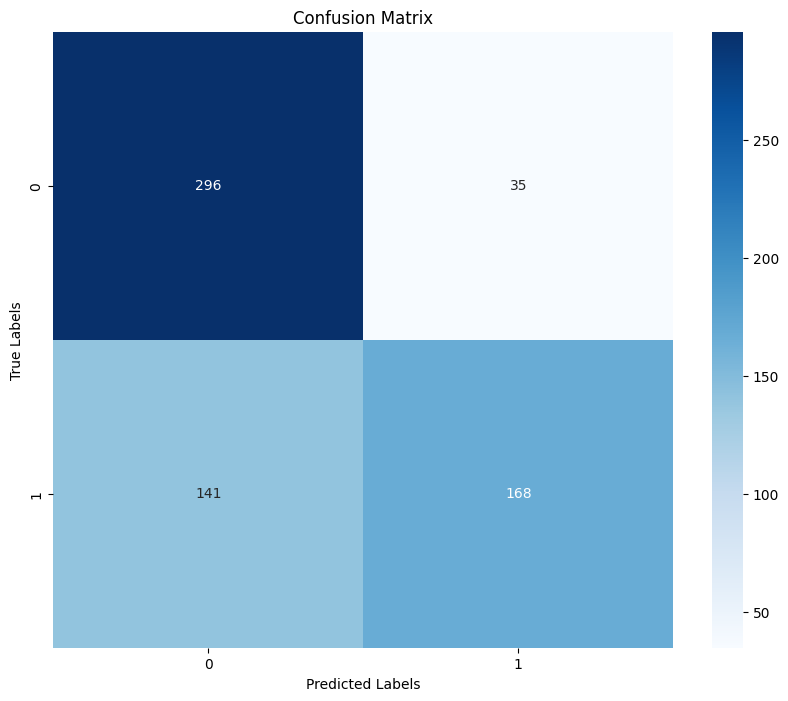

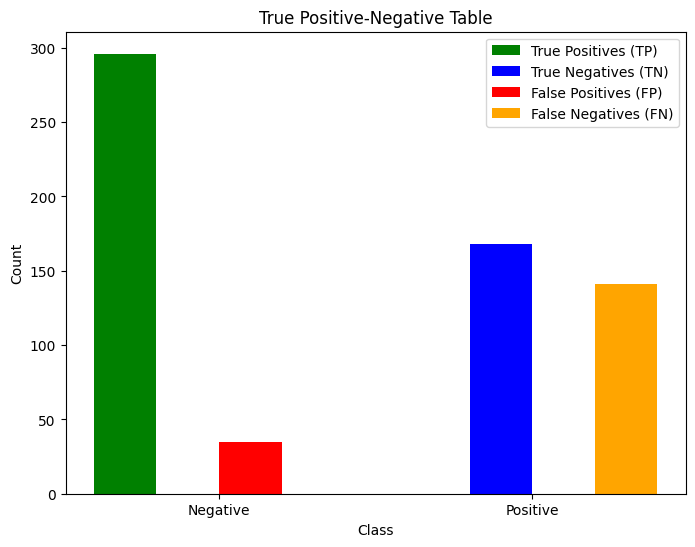

In [179]:
import numpy as np
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense
import tensorflow as tf

#Code adapted from OpenAI's ChatGPT

# Hyperparameter options
embedding_dims = [50, 100, 200]
neuron_options = [64, 128, 256]
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [32, 64, 128]
num_epochs = [10, 20, 30]

#embedding_dims = [100]
#neuron_options = [128]
#learning_rates = [0.001]
#batch_sizes = [128]
#num_epochs = [20]

# Define the number of folds
k = 5

# Initialize k-fold cross-validation
kf = KFold(n_splits=k, shuffle=True)

# Function to create and compile the model
def create_model(embedding_dim, neurons, learning_rate):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim),
        GlobalAveragePooling1D(),
        Dense(neurons, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Dictionary to store results
results = {}

# Manual loop through hyperparameters
for embedding_dim in embedding_dims:
    for neurons in neuron_options:
        for learning_rate in learning_rates:
            for batch_size in batch_sizes:
                for epoch in num_epochs:
                    validation_accuracies = []
                    
                    # K-fold cross-validation
                    for train_index, val_index in kf.split(train_sequences):
                        X_train, X_val = train_sequences[train_index], train_sequences[val_index]
                        y_train, y_val = train_labels[train_index], train_labels[val_index]

                        # Create and compile the model
                        model = create_model(embedding_dim, neurons, learning_rate)
                        
                        # Train the model
                        model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, verbose=0)
                        
                        # Evaluate the model on the validation set
                        _, val_acc = model.evaluate(X_val, y_val, verbose=0)
                        validation_accuracies.append(val_acc)
                    
                    # Average validation accuracy
                    avg_val_acc = np.mean(validation_accuracies)
                    param_combination = (embedding_dim, neurons, learning_rate, batch_size, epoch)
                    results[param_combination] = avg_val_acc

# Find the best hyperparameters
best_params = max(results, key=results.get)
best_accuracy = results[best_params]

print(f"Best validation accuracy: {best_accuracy:.4f} with parameters: embedding_dim={best_params[0]}, neurons={best_params[1]}, learning_rate={best_params[2]}, batch_size={best_params[3]}, epochs={best_params[4]}")

# Create and compile the final model with the best hyperparameters
best_model = create_model(best_params[0], best_params[1], best_params[2])

# Train the final model on the entire training set
best_model.fit(train_sequences, train_labels, epochs=best_params[4], batch_size=best_params[3], verbose=0)

# Evaluate the final model on the validation set
val_loss, val_acc = best_model.evaluate(val_sequences, val_labels)
print(f'Validation accuracy of the best model: {val_acc:.4f}')

# Predict labels for the validation set
val_pred_probs = best_model.predict(val_sequences)
val_preds = np.argmax(val_pred_probs, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(val_labels, val_preds)

# Print classification report for more detailed metrics
print(classification_report(val_labels, val_preds))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Define class names
class_names = ['Negative', 'Positive']

# Calculate True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN)
TP = conf_matrix[0, 0]
TN = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

# Plotting the true positive-negative table with each metric on its own line
plt.figure(figsize=(8, 6))

# Define the positions for each class
class_positions = np.arange(len(class_names))

# Define the width for each bar
bar_width = 0.2

# Plot True Positives (TP)
plt.bar(class_positions - 1.5 * bar_width, [TP, 0], bar_width, color='green', label='True Positives (TP)')

# Plot True Negatives (TN)
plt.bar(class_positions - 0.5 * bar_width, [0, TN], bar_width, color='blue', label='True Negatives (TN)')

# Plot False Positives (FP)
plt.bar(class_positions + 0.5 * bar_width, [FP, 0], bar_width, color='red', label='False Positives (FP)')

# Plot False Negatives (FN)
plt.bar(class_positions + 1.5 * bar_width, [0, FN], bar_width, color='orange', label='False Negatives (FN)')

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('True Positive-Negative Table')
plt.xticks(class_positions, class_names)
plt.legend()
plt.show()

# Recurrent Neural Network

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

#Code adapted from OpenAI's ChatGPT

# Define vocabulary size and maximum sequence length
vocab_size = len(tokenizer.word_index) + 1  # Add 1 for the padding token
max_sequence_length = max(len(sequence) for sequence in train_sequences)

# Define RNN model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, input_length=max_sequence_length),
    LSTM(64, return_sequences=True),  # You can add more LSTM layers if needed
    #Dropout(0.5), 
    LSTM(64),  # You can add more LSTM layers if needed
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification, so sigmoid activation
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(train_sequences, train_labels, epochs=10, validation_data=(val_sequences, val_labels))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(val_sequences, val_labels)
print("Test Accuracy:", test_accuracy)


NameError: name 'tokenizer' is not defined

## RNN Varying hyper-parameters

Through various iterations of constructing the RNN was ultimately decided the best way to find the most accurate hyper-parameters was to use an exhaustive search, this allowed for the most effective parameters to be found.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7530 - loss: 0.5188
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7434 - loss: 0.5204
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7590 - loss: 0.5364
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7465 - loss: 0.5624
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.7774 - loss: 0.5366
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.7510 - loss: 0.5335
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
Best Validation Accuracy: 0.7656
Best LSTM Units: 128
Best Dropout Rate: 0.2


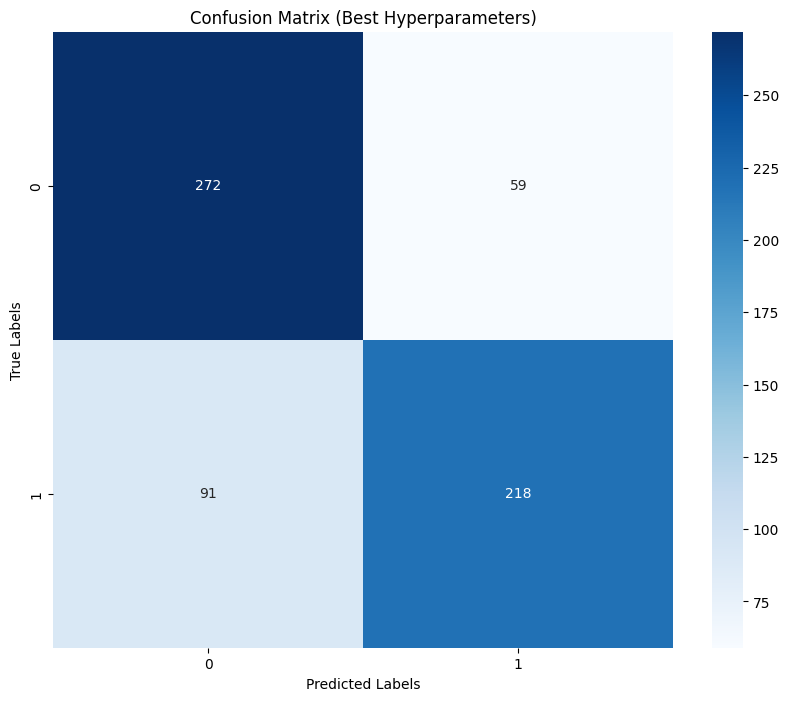

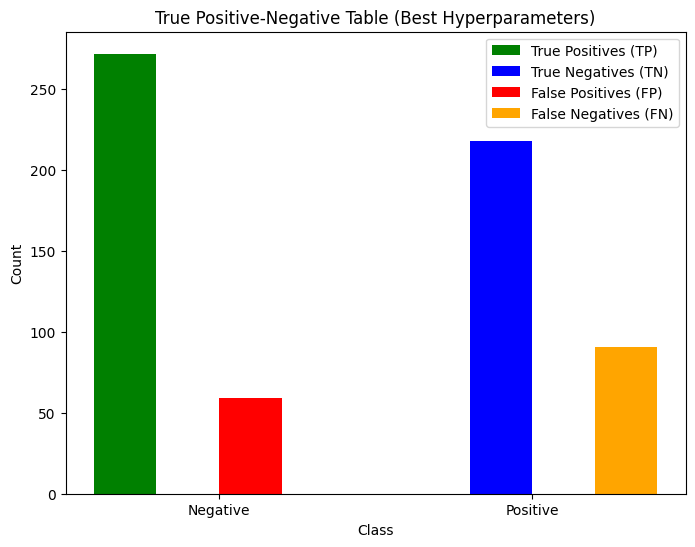

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#Code adapted from OpenAI's ChatGPT

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_sentences)
train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sequences = tokenizer.texts_to_sequences(val_sentences)

num_epochs = 10

# Pad sequences to ensure uniform length
#max_sequence_length = 100  # Adjust as needed
max_sequence_length_train = max(len(sequence) for sequence in train_sequences)

# Find the maximum sequence length in the validation set
max_sequence_length_val = max(len(sequence) for sequence in val_sequences)

# Determine the maximum sequence length across both training and validation sets
max_sequence_length = max(max_sequence_length_train, max_sequence_length_val)
#max_sequence_length = 100
train_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length)
val_sequences = pad_sequences(val_sequences, maxlen=max_sequence_length)

# Define your neural network architecture
vocab_size = len(tokenizer.word_index) + 1  # Add 1 for the padding token
embedding_dim = 100  # Adjust as needed
num_classes = 2  # 2 used as this section is binary classification related

# Define the hyperparameters to search
lstm_units_values = [32, 64, 128]
dropout_rate_values = [0.2, 0.5]

# Initialize variables to store best values and results
best_accuracy = 0
best_lstm_units = 0
best_dropout_rate = 0
best_conf_matrix = None

# Initialize empty lists to store results
accuracies = []
confusion_matrices = []

# Loop through hyperparameters
for lstm_units in lstm_units_values:
    for dropout_rate in dropout_rate_values:
        # Create and compile the model
        model = Sequential([
            Embedding(input_dim=vocab_size, output_dim=100, input_length=max_sequence_length),
            LSTM(lstm_units, return_sequences=True),
            Dropout(dropout_rate),
            LSTM(lstm_units),
            Dropout(dropout_rate),
            Dense(64, activation='relu'),
            Dense(1, activation='sigmoid')
        ])

        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        # Train the model
        history = model.fit(train_sequences, train_labels, epochs=2, validation_data=(val_sequences, val_labels), verbose=0)

        # Evaluate the model
        val_loss, val_accuracy = model.evaluate(val_sequences, val_labels)
        accuracies.append((lstm_units, dropout_rate, val_accuracy))
        
        # Generate the confusion matrix
        y_pred_probs = model.predict(val_sequences)
        y_pred = np.where(y_pred_probs > 0.5, 1, 0)  # Threshold at 0.5 for binary classification
        conf_matrix = confusion_matrix(val_labels, y_pred)
        confusion_matrices.append((lstm_units, dropout_rate, conf_matrix))
        
        # Update best values if necessary
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_lstm_units = lstm_units
            best_dropout_rate = dropout_rate
            best_conf_matrix = conf_matrix

# Print the best hyperparameters
print(f"Best Validation Accuracy: {best_accuracy:.4f}")
print(f"Best LSTM Units: {best_lstm_units}")
print(f"Best Dropout Rate: {best_dropout_rate}")

# Plot confusion matrix for best hyperparameters
plt.figure(figsize=(10, 8))
sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Best Hyperparameters)')
plt.show()

# Plot true positive-negative table for best hyperparameters
TP = best_conf_matrix[0, 0]
TN = best_conf_matrix[1, 1]
FP = best_conf_matrix[0, 1]
FN = best_conf_matrix[1, 0]

class_names = ['Negative', 'Positive']
plt.figure(figsize=(8, 6))
class_positions = np.arange(len(class_names))
bar_width = 0.2

plt.bar(class_positions - 1.5 * bar_width, [TP, 0], bar_width, color='green', label='True Positives (TP)')
plt.bar(class_positions - 0.5 * bar_width, [0, TN], bar_width, color='blue', label='True Negatives (TN)')
plt.bar(class_positions + 0.5 * bar_width, [FP, 0], bar_width, color='red', label='False Positives (FP)')
plt.bar(class_positions + 1.5 * bar_width, [0, FN], bar_width, color='orange', label='False Negatives (FN)')

plt.xlabel('Class')
plt.ylabel('Count')
plt.title('True Positive-Negative Table (Best Hyperparameters)')
plt.xticks(class_positions, class_names)
plt.legend()
plt.show()

#plot_model(model, to_file='rnn_model.png', show_shapes=True)


AttributeError: module 'pydot' has no attribute 'InvocationException'

# Task 2

This task is to classify based on snippets from within sentences rather than the whole sentence. The data is also labelled into 9 labels, 8 of which are variations of propaganda and the remaining label is not_propaganda

### Opening Files
The code in the code tab below is to openthe files anew - seperate from task 1. This allowed for independent running. The differing variable names also allowed for the state of the data to be known before running the following code (for if the variables were just re-used from task 1, there could have been processing done on them). 

In [10]:
import nltk
import ssl
#Code adapted from OpenAI's ChatGPT
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/finpearson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/finpearson/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import pandas as pd
from sklearn.utils import resample

#Code adapted from OpenAI's ChatGPT

# import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')

# Read train and validation data
task2_train_df = pd.read_csv(train_path, delimiter="\t", quotechar='|')
task2_val_df = pd.read_csv(val_path, delimiter="\t", quotechar='|')

# Extract propaganda snippet from tagged_in_context column for train_df
task2_train_snippets = task2_train_df['tagged_in_context'].apply(lambda x: x.split('<BOS>')[-1].split('<EOS>')[0].strip())
task2_train_labels = task2_train_df['label'].values

# Extract propaganda snippet from tagged_in_context column for val_df
task2_val_snippets = task2_val_df['tagged_in_context'].apply(lambda x: x.split('<BOS>')[-1].split('<EOS>')[0].strip())
task2_val_labels = task2_val_df['label'].values

# Function to clean text
def clean_text(text):
    text = text.lower()  # Lowercase the text
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and special characters
    text = text.split()  # Tokenize
    text = [word for word in text if word not in stopwords.words('english')]  # Remove stop words
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]  # Lemmatization
    return ' '.join(text)

# Apply text cleaning to the data
task2_train_snippets = task2_train_snippets.apply(clean_text)
task2_val_snippets = task2_val_snippets.apply(clean_text)

# Concatenate the snippets and labels for easier manipulation
train_data = pd.concat([task2_train_snippets, pd.Series(task2_train_labels, name='label')], axis=1)

# List of unique labels excluding 'not_propaganda'
unique_labels = task2_train_df['label'].unique()
unique_labels = [label for label in unique_labels if label != 'not_propaganda']

# Dictionary to store the number of instances for each label
label_counts = {}

# Count instances for each label
for label in unique_labels:
    label_counts[label] = len(train_data[train_data['label'] == label])

# Count instances for "not_propaganda" class separately
not_propaganda_count = len(train_data[train_data['label'] == 'not_propaganda'])

# Display labels and number of instances before undersampling
print("Before Undersampling:")
print(f"Label: not_propaganda, Number of Instances: {not_propaganda_count}")
for label, count in label_counts.items():
    if label != 'not_propaganda':
        print(f"Label: {label}, Number of Instances: {count}")
        
# Find the minimum number of instances among the non-'not_propaganda' labels
min_instances = min(label_counts.values())

# Downsample 'not_propaganda' class
not_propaganda = train_data[train_data['label'] == 'not_propaganda']
downsampled_not_propaganda = resample(not_propaganda,
                                      replace=False,
                                      n_samples=min_instances,
                                      random_state=42)

# List to store downsampled dataframes for each label
downsampled_dfs = [downsampled_not_propaganda]

# Downsample other classes using the minimum number of instances
for label in unique_labels:
    if label != 'not_propaganda':
        label_data = train_data[train_data['label'] == label]
        downsampled_label = resample(label_data,
                                     replace=False,
                                     n_samples=min_instances,
                                     random_state=42)
        downsampled_dfs.append(downsampled_label)

# Combine downsampled dataframes
balanced_train_data = pd.concat(downsampled_dfs)

# Shuffle the data
balanced_train_data = balanced_train_data.sample(frac=1, random_state=42)

# Separate snippets and labels
balanced_task2_train_snippets = balanced_train_data['tagged_in_context']
balanced_task2_train_labels = balanced_train_data['label']


Before Undersampling:
Label: not_propaganda, Number of Instances: 1269
Label: flag_waving, Number of Instances: 155
Label: loaded_language, Number of Instances: 161
Label: doubt, Number of Instances: 157
Label: name_calling,labeling, Number of Instances: 166
Label: appeal_to_fear_prejudice, Number of Instances: 157
Label: repetition, Number of Instances: 160
Label: causal_oversimplification, Number of Instances: 165
Label: exaggeration,minimisation, Number of Instances: 170


## RNN with LSTM Layers 

In [28]:
import numpy as np
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Code adapted from OpenAI's ChatGPT

# Preprocessing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(task2_train_snippets)
vocab_size = len(tokenizer.word_index) + 1
max_sequence_length = max([len(text.split()) for text in task2_train_snippets])

# Transform text from words to integer representing word in word dictionary
X_train_seq = tokenizer.texts_to_sequences(task2_train_snippets)
X_val_seq = tokenizer.texts_to_sequences(task2_val_snippets)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_sequence_length, padding='post')

# Encode the labels into integer values
encoder = LabelEncoder()
encoder.fit(task2_train_labels)
encoded_y_train = encoder.transform(task2_train_labels)
encoded_y_val = encoder.transform(task2_val_labels)
num_classes = len(encoder.classes_)

# Hyperparameter options
embedding_dims = [200]
neuron_options = [256]
learning_rates = [0.0001]
batch_sizes = [128]
num_epochs = [30]

# Define the number of folds
k = 5

# Initialize k-fold cross-validation
kf = KFold(n_splits=k, shuffle=True)

# Function to create and compile the model
def create_model(embedding_dim, neurons, learning_rate):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
        LSTM(neurons, return_sequences=True),
        Dropout(0.5),
        LSTM(neurons),
        Dropout(0.5),
        Dense(neurons, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Dictionary to store results
results = {}

# Manual loop through hyperparameters
for embedding_dim in embedding_dims:
    for neurons in neuron_options:
        for learning_rate in learning_rates:
            for batch_size in batch_sizes:
                for epoch in num_epochs:
                    validation_accuracies = []
                    
                    # K-fold cross-validation
                    for train_index, val_index in kf.split(X_train_pad):
                        X_train_fold, X_val_fold = X_train_pad[train_index], X_train_pad[val_index]
                        y_train_fold, y_val_fold = encoded_y_train[train_index], encoded_y_train[val_index]

                        # Create and compile the model
                        model = create_model(embedding_dim, neurons, learning_rate)
                        
                        # Train the model
                        model.fit(X_train_fold, y_train_fold, epochs=epoch, batch_size=batch_size, verbose=0)
                        
                        # Evaluate the model on the validation set
                        _, val_acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)
                        validation_accuracies.append(val_acc)
                    
                    # Average validation accuracy
                    avg_val_acc = np.mean(validation_accuracies)
                    param_combination = (embedding_dim, neurons, learning_rate, batch_size, epoch)
                    results[param_combination] = avg_val_acc

# Find the best hyperparameters
best_params = max(results, key=results.get)
best_accuracy = results[best_params]

print(f"Best validation accuracy: {best_accuracy:.4f} with parameters: embedding_dim={best_params[0]}, neurons={best_params[1]}, learning_rate={best_params[2]}, batch_size={best_params[3]}, epochs={best_params[4]}")

# Create and compile the final model with the best hyperparameters
best_model = create_model(best_params[0], best_params[1], best_params[2])

# Train the final model on the entire training set
best_model.fit(X_train_pad, encoded_y_train, epochs=best_params[4], batch_size=best_params[3], verbose=0)

# Evaluate the final model on the validation set
val_loss, val_acc = best_model.evaluate(X_val_pad, encoded_y_val)
print(f'Validation accuracy of the best model: {val_acc:.4f}')

# Predict labels for the validation set
y_val_pred = best_model.predict(X_val_pad)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(encoded_y_val, y_val_pred_classes)

# Print classification report for more detailed metrics
print(classification_report(encoded_y_val, y_val_pred_classes, target_names=encoder.classes_))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Define class names and metrics
class_names = encoder.classes_
metrics = ['TP', 'TN', 'FP', 'FN']
counts = []

# Calculate counts for each metric
for i in range(len(class_names)):
    TP = conf_matrix[i, i]
    FN = np.sum(conf_matrix[i, :]) - TP
    FP = np.sum(conf_matrix[:, i]) - TP
    TN = np.sum(conf_matrix) - TP - FN - FP
    counts.append([TP, TN, FP, FN])

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Set width of bars
bar_width = 0.2

# Set position of bar on X axis
bar_positions = np.arange(len(class_names))

# Plot bars
for i in range(len(metrics)):
    ax.bar(bar_positions + i * bar_width, [count[i] for count in counts], bar_width, label=metrics[i])

# Adding labels
ax.set_xlabel('Classes')
ax.set_ylabel('Counts')
ax.set_title('Counts of TP, TN, FP, and FN for each Class')
ax.set_xticks(bar_positions + bar_width * 1.5)
ax.set_xticklabels(class_names, rotation=90, va='center')
ax.legend()

# Adjust position of x-axis labels
for tick in ax.get_xticklabels():
    tick.set_y(-0.15)

plt.show()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


KeyboardInterrupt: 

Best validation accuracy: 0.4965 with parameters: embedding_dim=50, neurons=64, learning_rate=0.001, batch_size=64, epochs=30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5146 - loss: 1.7131
Validation accuracy of the best model: 0.5172
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.00      0.00      0.00        43
causal_oversimplification       0.00      0.00      0.00        35
                    doubt       0.00      0.00      0.00        43
exaggeration,minimisation       0.00      0.00      0.00        30
              flag_waving       0.00      0.00      0.00        45
          loaded_language       0.00      0.00      0.00        39
    name_calling,labeling       0.00      0.00      0.00        34
           not_propaganda       0.52      1.00      0.68       331
               repetition       0.00      0.00      0.00        40

                 accuracy                  

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

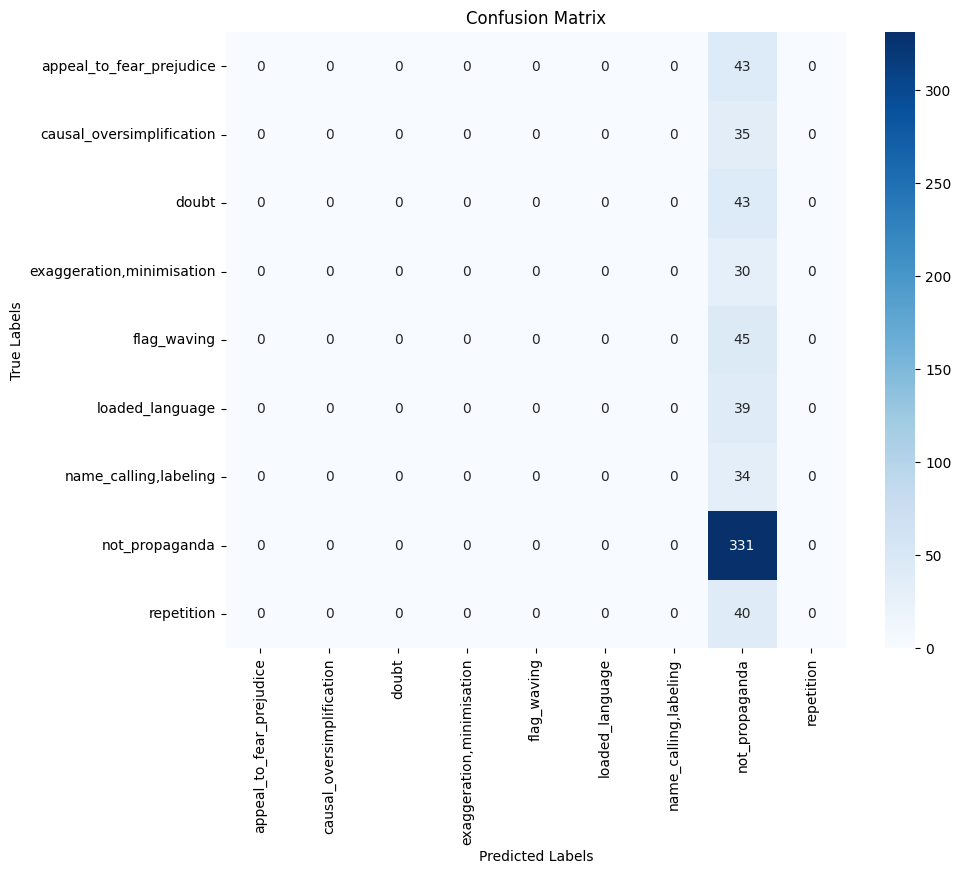

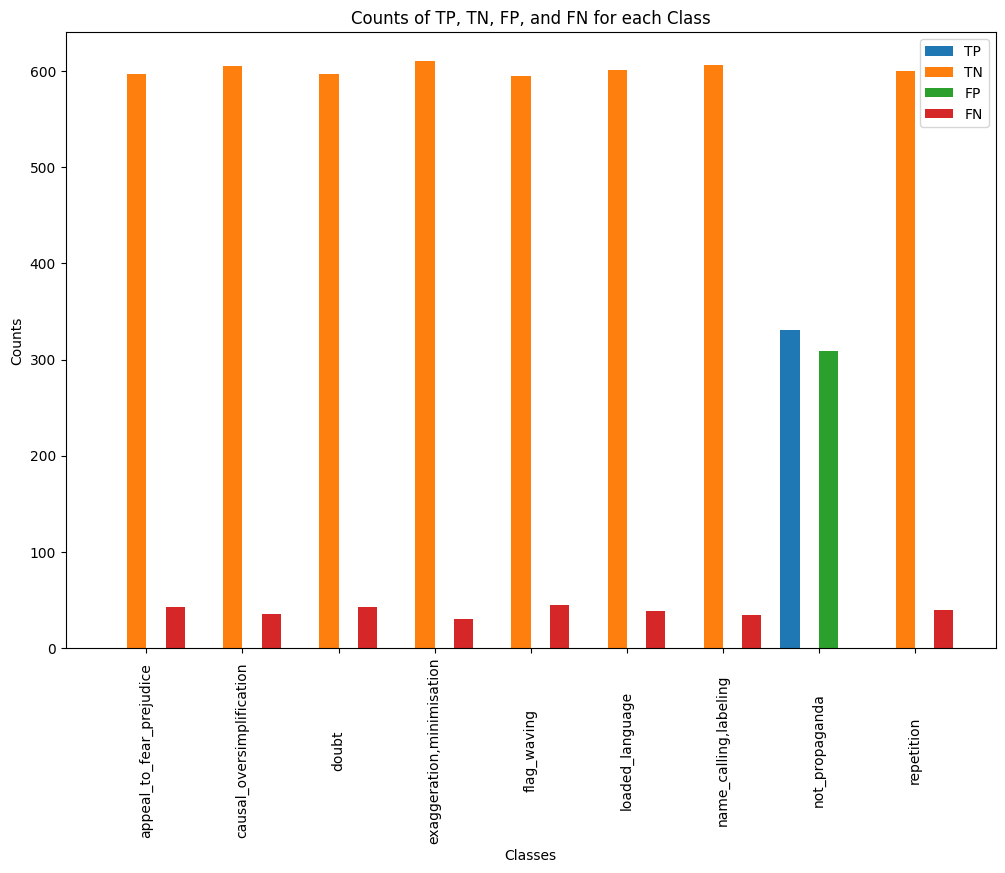

In [26]:
#Code adapted from OpenAI's ChatGPT

# Find the best hyperparameters
best_params = max(results, key=results.get)
best_accuracy = results[best_params]

print(f"Best validation accuracy: {best_accuracy:.4f} with parameters: embedding_dim={best_params[0]}, neurons={best_params[1]}, learning_rate={best_params[2]}, batch_size={best_params[3]}, epochs={best_params[4]}")

# Create and compile the final model with the best hyperparameters
best_model = create_model(best_params[0], best_params[1], best_params[2])

# Train the final model on the entire training set
best_model.fit(X_train_pad, encoded_y_train, epochs=best_params[4], batch_size=best_params[3], verbose=0)

# Evaluate the final model on the validation set
val_loss, val_acc = best_model.evaluate(X_val_pad, encoded_y_val)
print(f'Validation accuracy of the best model: {val_acc:.4f}')

# Predict labels for the validation set
y_val_pred = best_model.predict(X_val_pad)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(encoded_y_val, y_val_pred_classes)

# Print classification report for more detailed metrics
print(classification_report(encoded_y_val, y_val_pred_classes, target_names=encoder.classes_))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Define class names and metrics
class_names = encoder.classes_
metrics = ['TP', 'TN', 'FP', 'FN']
counts = []

# Calculate counts for each metric
for i in range(len(class_names)):
    TP = conf_matrix[i, i]
    FN = np.sum(conf_matrix[i, :]) - TP
    FP = np.sum(conf_matrix[:, i]) - TP
    TN = np.sum(conf_matrix) - TP - FN - FP
    counts.append([TP, TN, FP, FN])

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Set width of bars
bar_width = 0.2

# Set position of bar on X axis
bar_positions = np.arange(len(class_names))

# Plot bars
for i in range(len(metrics)):
    ax.bar(bar_positions + i * bar_width, [count[i] for count in counts], bar_width, label=metrics[i])

# Adding labels
ax.set_xlabel('Classes')
ax.set_ylabel('Counts')
ax.set_title('Counts of TP, TN, FP, and FN for each Class')
ax.set_xticks(bar_positions + bar_width * 1.5)
ax.set_xticklabels(class_names, rotation=90, va='center')
ax.legend()

# Adjust position of x-axis labels
for tick in ax.get_xticklabels():
    tick.set_y(-0.15)

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Code adapted from OpenAI's ChatGPT

# Preprocessing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(task2_train_snippets)
vocab_size = len(tokenizer.word_index) + 1
max_sequence_length = max([len(text.split()) for text in task2_train_snippets])

# Transform text from words to integers representing words in the word dictionary
X_train_seq = tokenizer.texts_to_sequences(task2_train_snippets)
X_val_seq = tokenizer.texts_to_sequences(task2_val_snippets)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_sequence_length, padding='post')

# Encode labels
encoder = LabelEncoder()
encoder.fit(task2_train_labels)
encoded_y_train = encoder.transform(task2_train_labels)
encoded_y_val = encoder.transform(task2_val_labels)
num_classes = len(encoder.classes_)
print("Num Classes", num_classes)

# Define the hyperparameters to search
lstm_units_values = [32, 64, 128]
dropout_rate_values = [0.2, 0.5]

# Initialize variables to store best values and results
best_accuracy = 0
best_lstm_units = 0
best_dropout_rate = 0
best_conf_matrix = None

# Initialize empty lists to store results
accuracies = []
confusion_matrices = []

# Loop through hyperparameters
for lstm_units in lstm_units_values:
    for dropout_rate in dropout_rate_values:
        # Build LSTM model
        lstm_model = Sequential([
            Embedding(input_dim=vocab_size, output_dim=100, input_length=max_sequence_length),
            LSTM(lstm_units, return_sequences=True),
            Dropout(dropout_rate),
            LSTM(lstm_units),
            Dropout(dropout_rate),
            Dense(64, activation='relu'),
            Dense(num_classes, activation='softmax')
        ])

        lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Train the model
        lstm_model.fit(X_train_pad, encoded_y_train, epochs=5, validation_data=(X_val_pad, encoded_y_val), verbose=0)

        # Evaluate the model
        val_loss, val_accuracy = lstm_model.evaluate(X_val_pad, encoded_y_val)
        accuracies.append((lstm_units, dropout_rate, val_accuracy))

        # Generate the confusion matrix
        y_val_pred_probs = lstm_model.predict(X_val_pad)
        y_val_pred_classes = np.argmax(y_val_pred_probs, axis=1)
        conf_matrix = confusion_matrix(encoded_y_val, y_val_pred_classes)

        confusion_matrices.append((lstm_units, dropout_rate, conf_matrix))

        # Update best values if necessary
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_lstm_units = lstm_units
            best_dropout_rate = dropout_rate
            best_conf_matrix = conf_matrix

# Print the best hyperparameters
print(f"Best Validation Accuracy: {best_accuracy:.4f}")
print(f"Best LSTM Units: {best_lstm_units}")
print(f"Best Dropout Rate: {best_dropout_rate}")

# Plot confusion matrix for best hyperparameters
plt.figure(figsize=(10, 8))
sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Best Hyperparameters)')
plt.show()

## BERT Large Pre-Trained Language Model

In [22]:
from tqdm import tqdm
from transformers import get_linear_schedule_with_warmup

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Code adapted from OpenAI's ChatGPT

# Encode labels
encoder = LabelEncoder()
encoder.fit(task2_train_labels)
encoded_y_train = encoder.transform(task2_train_labels)
encoded_y_val = encoder.transform(task2_val_labels)
num_classes = len(encoder.classes_)

# Tokenize input data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

train_encodings = tokenizer(task2_train_snippets.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(task2_val_snippets.tolist(), truncation=True, padding=True)

# Create PyTorch datasets
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                              torch.tensor(encoded_y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']),
                            torch.tensor(val_encodings['attention_mask']),
                            torch.tensor(encoded_y_val, dtype=torch.long))

# Define data loaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)
model.to(device)

# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 1
total_steps = len(train_loader) * num_epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0, 
                                            num_training_steps=total_steps)

# Training loop
model.train()
for epoch in range(num_epochs):
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        input_ids, attention_mask, labels = batch

        # Move the batch to the device
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

torch.save(model.state_dict(), 'modelNormalWith1EpochsAndPreProcessing.pth')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/1:   0%|          | 0/320 [00:04<?, ?it/s]


KeyboardInterrupt: 

## Second Attempt BERT with gloVe

In [89]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from transformers import BertTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.preprocessing import LabelEncoder

# Assuming task2_train_snippets, task2_val_snippets, task2_train_labels, task2_val_labels are already defined

#Code adapted from OpenAI's ChatGPT

# Load the GloVe embeddings
def load_glove_embeddings(path):
    embeddings_dict = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector
    return embeddings_dict

glove_path = '/Users/finpearson/Desktop/Github/ANLE---Python-/Project/glove.6B.100d.txt'  # Update the path to where the GloVe file is located
glove_embeddings = load_glove_embeddings(glove_path)

# Create an embedding matrix
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
embedding_matrix = np.zeros((len(tokenizer.vocab), 100))
for word, idx in tokenizer.vocab.items():
    if word in glove_embeddings:
        embedding_matrix[idx] = glove_embeddings[word]
    else:
        embedding_matrix[idx] = np.random.rand(100)  # Random vector for unknown words

# Encode labels
encoder = LabelEncoder()
encoder.fit(task2_train_labels)
encoded_y_train = encoder.transform(task2_train_labels)
encoded_y_val = encoder.transform(task2_val_labels)
num_classes = len(encoder.classes_)

# Tokenize input data
train_encodings = tokenizer(task2_train_snippets.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(task2_val_snippets.tolist(), truncation=True, padding=True)

# Create PyTorch datasets
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                              torch.tensor(encoded_y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']),
                            torch.tensor(val_encodings['attention_mask']),
                            torch.tensor(encoded_y_val, dtype=torch.long))

# Define data loaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Custom model using GloVe embeddings
class CustomModel(nn.Module):
    def __init__(self, embedding_matrix, num_classes):
        super(CustomModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float), freeze=False)
        self.fc = nn.Linear(100, num_classes)  # Assuming 100 is the embedding size

    def forward(self, input_seq, attention_mask=None):
        embedded_seq = self.embedding(input_seq)
        pooled_output = torch.mean(embedded_seq, 1)  # Simple mean pooling
        logits = self.fc(pooled_output)
        return logits

# Initialize custom model
model = CustomModel(embedding_matrix, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 1
total_steps = len(train_loader) * num_epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0, 
                                            num_training_steps=total_steps)

# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Training loop
model.train()
for epoch in range(num_epochs):
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        input_ids, attention_mask, labels = batch

        # Move the batch to the device
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

torch.save(model.state_dict(), 'modelUsingGlove.pth')


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/1: 100%|██████████| 320/320 [00:02<00:00, 120.14it/s]


### Second Attempt BERT with gloVe evaluator

Validation Accuracy: 0.0469


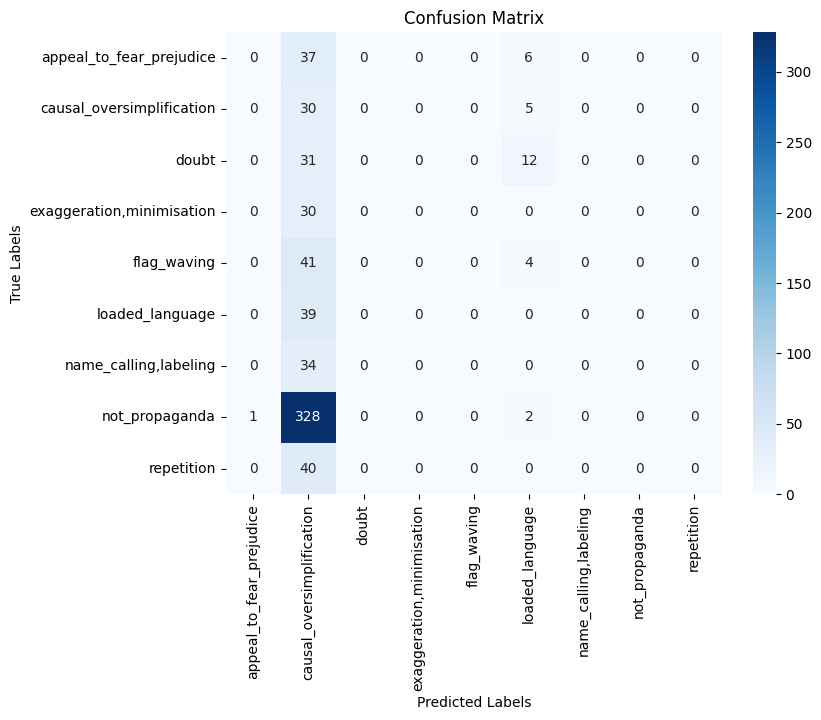

In [153]:
#Code adapted from OpenAI's ChatGPT

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
embedding_matrix = np.zeros((len(tokenizer.vocab), 100))
for word, idx in tokenizer.vocab.items():
    if word in glove_embeddings:
        embedding_matrix[idx] = glove_embeddings[word]
    else:
        embedding_matrix[idx] = np.random.rand(100)  # Random vector for unknown words

# Encode labels
encoder = LabelEncoder()
encoder.fit(task2_train_labels)
encoded_y_train = encoder.transform(task2_train_labels)
encoded_y_val = encoder.transform(task2_val_labels)
num_classes = len(encoder.classes_)
model = CustomModel(embedding_matrix, num_classes)
# Assuming you have a validation loop after the training loop
model.load_state_dict(torch.load('modelUsingGlove.pth'))


# Validation loop
model.eval()  # Set the model to evaluation mode
val_losses = []
val_preds = []

with torch.no_grad():  # No need to track gradients during validation
    for batch in val_loader:
        input_ids, attention_mask, labels = batch

        # Move the batch to the device
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        logits = model(input_ids, attention_mask=attention_mask)  # Directly get the logits from the model
        loss = loss_fn(logits, labels)  # Compute the loss using the logits and the labels

        val_losses.append(loss.item())  # Store the loss value
        val_preds.extend(torch.argmax(logits, axis=1).tolist())  # Store the predicted classes

# Now you can use val_losses and val_preds as needed for validation metrics


# Continue from the previous validation loop code

# Convert the list of labels from the DataLoader to a tensor for comparison
true_labels = torch.cat([labels for _, _, labels in val_loader]).to(device)

# Convert the list of predictions to a tensor
predicted_labels = torch.tensor(val_preds).to(device)

# Calculate the number of correct predictions
correct_predictions = (predicted_labels == true_labels).sum().item()

# Calculate the total number of labels
total_labels = true_labels.size(0)

# Calculate the accuracy
accuracy = correct_predictions / total_labels

print(f'Validation Accuracy: {accuracy:.4f}')

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels.cpu(), predicted_labels.cpu())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### First iteration of BERT evaluator

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 80/80 [00:26<00:00,  3.05it/s]


Validation Accuracy: 0.5375
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.53      0.19      0.28        43
causal_oversimplification       1.00      0.03      0.06        35
                    doubt       0.50      0.07      0.12        43
exaggeration,minimisation       0.38      0.27      0.31        30
              flag_waving       0.71      0.33      0.45        45
          loaded_language       0.29      0.64      0.40        39
    name_calling,labeling       0.43      0.35      0.39        34
           not_propaganda       0.73      0.75      0.74       331
               repetition       0.19      0.57      0.29        40

                 accuracy                           0.54       640
                macro avg       0.53      0.36      0.34       640
             weighted avg       0.62      0.54      0.52       640



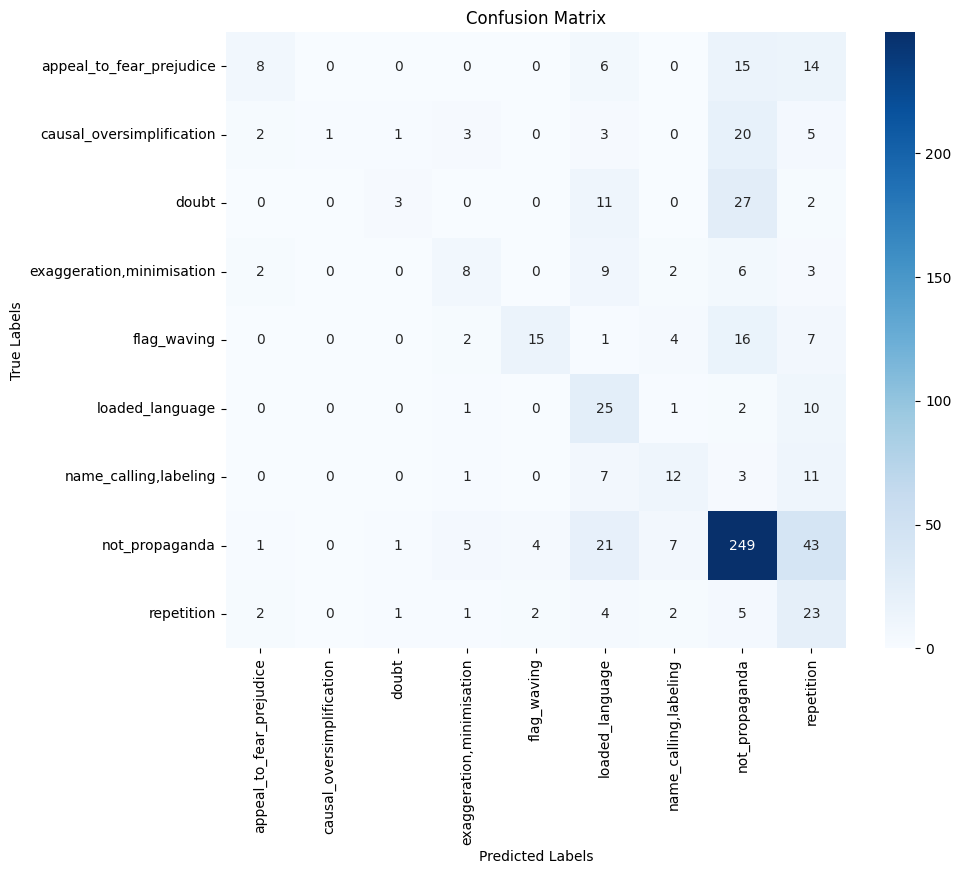

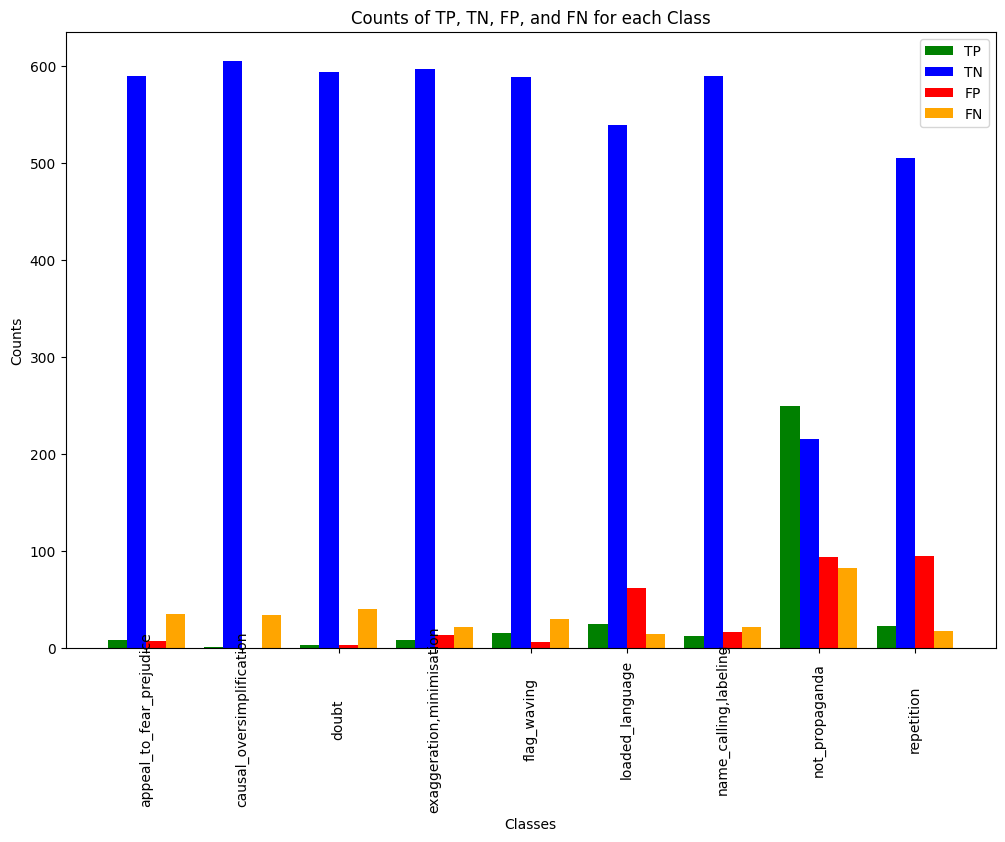

In [23]:
import torch
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertForSequenceClassification
# Evaluation
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)
#model.load_state_dict(torch.load('model.pth'))
#model.load_state_dict(torch.load('modelNormalWith3Epochs.pth'))
model.load_state_dict(torch.load('modelNormalWith6Epochs.pth'))
#model.load_state_dict(torch.load('modelNormalWith1EpochsAndPreProcessing.pth'))
#val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
model.eval()
val_losses = []
val_preds = []
val_targets = []
with torch.no_grad():
    for batch in tqdm(val_loader, desc='Validation'):
        input_ids, attention_mask, labels = batch

        # Move the batch to the device
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = outputs.loss
        logits = outputs.logits
        if loss is not None:
            val_losses.append(loss.item())
        val_preds.extend(torch.argmax(logits, axis=1).tolist())
        val_targets.extend(labels.tolist())

val_accuracy = np.mean(np.array(val_preds) == np.array(val_targets))
print(f"Validation Accuracy: {val_accuracy}")

# Generate the confusion matrix
conf_matrix = confusion_matrix(val_targets, val_preds)

# Print classification report for more detailed metrics
print(classification_report(val_targets, val_preds, target_names=encoder.classes_))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate TP, TN, FP, FN for each class
counts = []
for i in range(len(encoder.classes_)):
    TP = np.sum((np.array(val_targets) == i) & (np.array(val_preds) == i))
    TN = np.sum((np.array(val_targets) != i) & (np.array(val_preds) != i))
    FP = np.sum((np.array(val_targets) != i) & (np.array(val_preds) == i))
    FN = np.sum((np.array(val_targets) == i) & (np.array(val_preds) != i))
    counts.append([TP, TN, FP, FN])

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Set width of bars
bar_width = 0.2

# Set position of bar on X axis
bar_positions = np.arange(len(encoder.classes_))

# Plot bars
metrics = ['TP', 'TN', 'FP', 'FN']
colors = ['green', 'blue', 'red', 'orange']
for i in range(len(metrics)):
    ax.bar(bar_positions + i * bar_width, [count[i] for count in counts], bar_width, label=metrics[i], color=colors[i])

# Adding labels
ax.set_xlabel('Classes')
ax.set_ylabel('Counts')
ax.set_title('Counts of TP, TN, FP, and FN for each Class')
ax.set_xticks(bar_positions + bar_width * 1.5)
ax.set_xticklabels(encoder.classes_, rotation=90, va='center')  # Rotate labels vertically
ax.legend()

# Adjust position of x-axis labels
for tick in ax.get_xticklabels():
    tick.set_y(-0.1)

plt.show()